# Setup enviorment

In [ ]:
%cd ..

In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor, preprocess_dataset_to_time_series

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/ResNet50V2_Per_Band/224_band1.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T=0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

## 2. Preprocessing

### Train Test split

In [5]:
train_df = dengue_df[:int(len(dengue_df)*(train_percentage/100))]
Municipalities_train = Municipalities[:int(len(dengue_df)*(train_percentage/100))]
test_df = dengue_df[int(len(dengue_df)*(train_percentage/100)):]
Municipalities_test = Municipalities[int(len(dengue_df)*(train_percentage/100)):]
#test_df

### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities_train)
test_df = pd.concat(test_df, keys=Municipalities_test)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities_train]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0    1         2        3         4    5    6    7    8  \
41001 201546 -1.0 -1.0 -0.974934 -0.71885 -0.901748 -1.0 -1.0 -1.0 -1.0   
      201547 -1.0 -1.0 -0.974934 -0.71885 -0.901748 -1.0 -1.0 -1.0 -1.0   
      201548 -1.0 -1.0 -0.974934 -0.71885 -0.901748 -1.0 -1.0 -1.0 -1.0   
      201549 -1.0 -1.0 -0.974934 -0.71885 -0.901748 -1.0 -1.0 -1.0 -1.0   
      201550 -1.0 -1.0 -0.974934 -0.71885 -0.901748 -1.0 -1.0 -1.0 -1.0   

                    9  ...  2039      2040      2041  2042  2043      2044  \
41001 201546 -0.96614  ...  -1.0 -0.859036 -0.799305  -1.0  -1.0 -0.931076   
      201547 -0.96614  ...  -1.0 -0.859036 -0.799305  -1.0  -1.0 -0.931076   
      201548 -0.96614  ...  -1.0 -0.859036 -0.799305  -1.0  -1.0 -0.931076   
      201549 -0.96614  ...  -1.0 -0.859036 -0.799305  -1.0  -1.0 -0.931076   
      201550 -0.96614  ...  -1.0 -0.859036 -0.799305  -1.0  -1.0 -0.931076   

              2045      2046  2047    Labels  
41001 201546  -1.0 -0.952606  -1.0 -0.861740  
      201547  -1.0 -0.952606  -1.0 -0.854589  
      201548  -1.0 -0.952606  -1.0 -0.856973  
      201549  -1.0 -0.952606  -1.0 -0.856973  
      201550  -1.0 -0.952606  -1.0 -0.823600  

[5 rows x 2049 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities_test]

test_df[1].head()

0    1         2        3         4    5         6         7  \
5360 201546 -1.0 -1.0 -0.974934 -0.71885 -0.901748 -1.0 -1.000000 -1.000000   
     201547 -1.0 -1.0 -0.717365 -1.00000 -0.995510 -1.0 -1.000000 -1.000000   
     201548 -1.0 -1.0 -0.974934 -0.71885 -0.901748 -1.0 -1.000000 -1.000000   
     201549 -1.0 -1.0 -0.617454 -1.00000 -1.000000 -1.0 -0.699488  0.019967   
     201550 -1.0 -1.0 -0.974934 -0.71885 -0.901748 -1.0 -1.000000 -1.000000   

               8        9  ...  2039      2040      2041  2042      2043  \
5360 201546 -1.0 -0.96614  ...  -1.0 -0.859036 -0.799305  -1.0 -1.000000   
     201547 -1.0 -1.00000  ...  -1.0 -0.985868 -1.000000  -1.0 -0.999066   
     201548 -1.0 -0.96614  ...  -1.0 -0.859036 -0.799305  -1.0 -1.000000   
     201549 -1.0 -1.00000  ...  -1.0 -0.795642 -1.000000  -1.0 -1.000000   
     201550 -1.0 -0.96614  ...  -1.0 -0.859036 -0.799305  -1.0 -1.000000   

                 2044  2045      2046      2047    Labels  
5360 201546 -0.931076  -1.0 -0.952606 -1.000000 -0.990465  
     201547 -1.000000  -1.0 -0.782908 -1.000000 -0.969011  
     201548 -0.931076  -1.0 -0.952606 -1.000000 -0.995232  
     201549 -0.265742  -1.0 -0.926185 -0.922251 -0.997616  
     201550 -0.931076  -1.0 -0.952606 -1.000000 -0.971395  

[5 rows x 2049 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(163, 2049)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities_train)
test = pd.concat(test, keys=Municipalities_test)

### Features and Labels Set

In [11]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1304, 2048)
The shape of the labels is (1304, 1)
Test:
The shape of the features is (326, 2048)
The shape of the labels is (326, 1)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

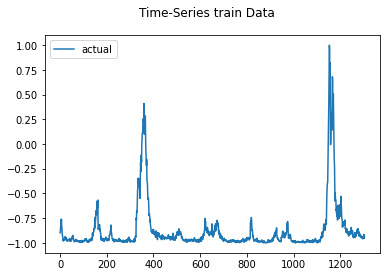

2023-03-06 14:07:49.342307: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-06 14:07:49.342356: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-06 14:07:49.342379: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9f7bdfccc75e): /proc/driver/nvidia/version does not exist
2023-03-06 14:07:49.342576: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 14:07:49.520431: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 56.315
Test RMSE: 88.701
Test sMAPE: 131.387
Test R Squared: -6.242
{'mae': 56.31517444550991, 'rmse': 88.701487026837, 'smape': 131.38739256068797, 'r2': -6.241828194317519}


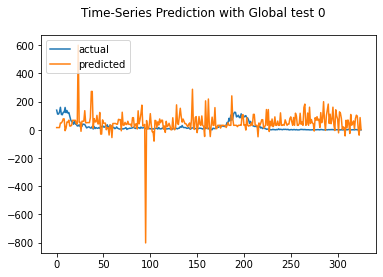

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 47.766
Test RMSE: 61.179
Test sMAPE: 132.434
Test R Squared: -2.445
{'mae': 47.76644179764335, 'rmse': 61.17877739374983, 'smape': 132.43361034034575, 'r2': -2.4449903020347006}


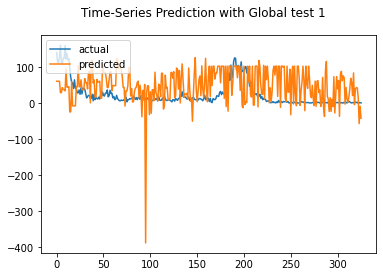

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 79.218
Test RMSE: 119.701
Test sMAPE: 151.309
Test R Squared: -12.188
{'mae': 79.21807910072292, 'rmse': 119.70103154121371, 'smape': 151.30867550589878, 'r2': -12.188099109925387}


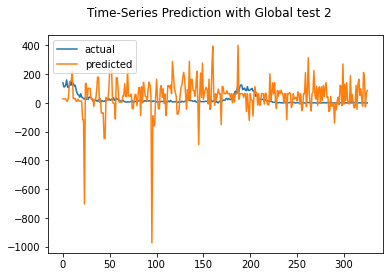

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 51.226
Test RMSE: 59.360
Test sMAPE: 138.364
Test R Squared: -2.243
{'mae': 51.22626228913939, 'rmse': 59.36003062337471, 'smape': 138.36414874684928, 'r2': -2.2432068516965735}


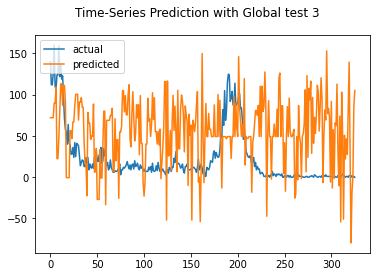

Test MAE: 65.824
Test RMSE: 80.956
Test sMAPE: 138.384
Test R Squared: -5.032
{'mae': 65.8242468731535, 'rmse': 80.95603261895704, 'smape': 138.38368420934827, 'r2': -5.0323266379720035}


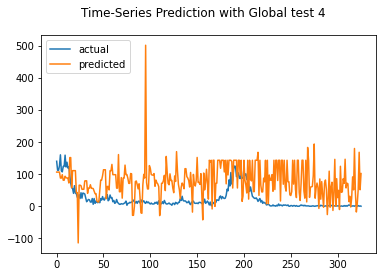

Test MAE: 94.745
Test RMSE: 119.875
Test sMAPE: 147.553
Test R Squared: -12.226
{'mae': 94.74536887999693, 'rmse': 119.87468758393673, 'smape': 147.5530304300696, 'r2': -12.226392085676606}


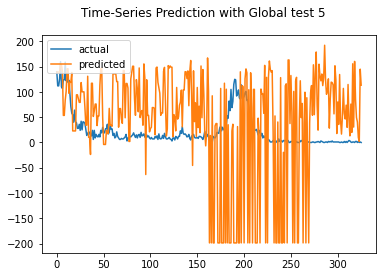

Test MAE: 70.495
Test RMSE: 79.639
Test sMAPE: 142.633
Test R Squared: -4.838
{'mae': 70.4947714472841, 'rmse': 79.63903962640464, 'smape': 142.63298046765607, 'r2': -4.837655263373822}


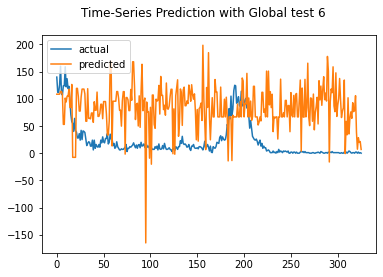

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 63.943
Test RMSE: 84.069
Test sMAPE: 139.752
Test R Squared: -5.505
{'mae': 63.94285416054579, 'rmse': 84.06857492721615, 'smape': 139.75204661216233, 'r2': -5.505097158332684}


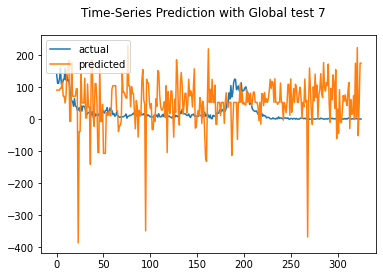

Test MAE: 88.503
Test RMSE: 124.487
Test sMAPE: 170.081
Test R Squared: -13.264
{'mae': 88.5025563767534, 'rmse': 124.4865924726543, 'smape': 170.08124157892036, 'r2': -13.263679598929924}


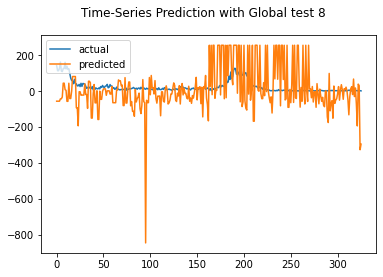

Test MAE: 70.389
Test RMSE: 104.863
Test sMAPE: 130.242
Test R Squared: -9.121
{'mae': 70.3891752351281, 'rmse': 104.86252266280952, 'smape': 130.24201547665132, 'r2': -9.12108375386574}


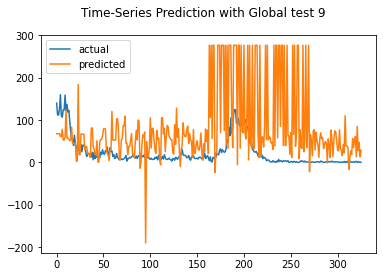

Test MAE: 69.009
Test RMSE: 85.234
Test sMAPE: 149.505
Test R Squared: -5.687
{'mae': 69.00874555147499, 'rmse': 85.23418759125435, 'smape': 149.5054829415607, 'r2': -5.686734324691643}


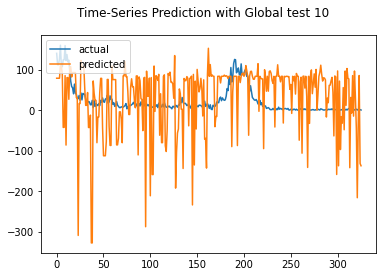

Test MAE: 82.938
Test RMSE: 113.168
Test sMAPE: 153.114
Test R Squared: -10.788
{'mae': 82.93829804329785, 'rmse': 113.16809409465404, 'smape': 153.11434635042357, 'r2': -10.787845088733711}


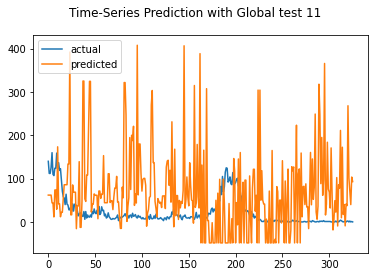

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 44.881
Test RMSE: 69.779
Test sMAPE: 130.454
Test R Squared: -3.482
{'mae': 44.881242594104606, 'rmse': 69.77850435326562, 'smape': 130.45404601854602, 'r2': -3.481565303089801}


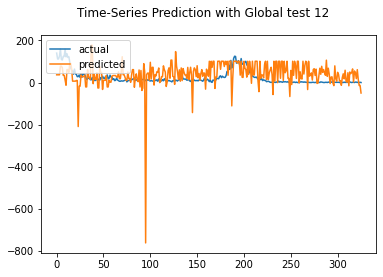

Test MAE: 56.603
Test RMSE: 66.964
Test sMAPE: 132.033
Test R Squared: -3.127
{'mae': 56.60346167731139, 'rmse': 66.96413856097011, 'smape': 132.0333094999451, 'r2': -3.127347056289442}


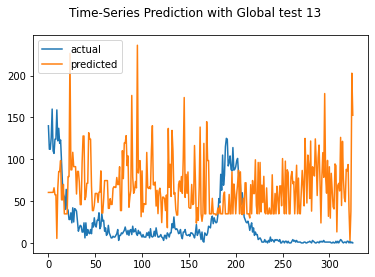

Test MAE: 44.902
Test RMSE: 69.995
Test sMAPE: 132.643
Test R Squared: -3.509
{'mae': 44.901660631313646, 'rmse': 69.99527681500653, 'smape': 132.64334357243405, 'r2': -3.5094532305251622}


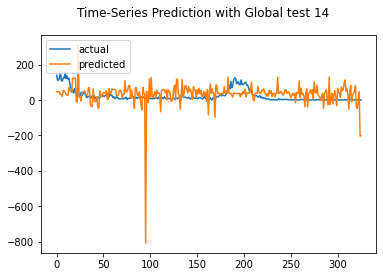

Test MAE: 65.073
Test RMSE: 83.050
Test sMAPE: 142.423
Test R Squared: -5.348
{'mae': 65.07295864491375, 'rmse': 83.04992202403037, 'smape': 142.42285916593934, 'r2': -5.348408643376447}


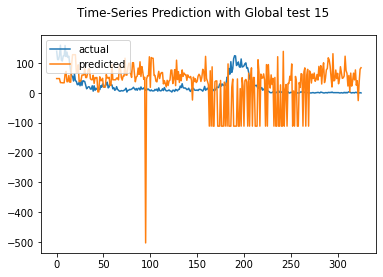

Test MAE: 82.171
Test RMSE: 107.832
Test sMAPE: 140.994
Test R Squared: -9.702
{'mae': 82.17068125792076, 'rmse': 107.83209014950387, 'smape': 140.99448838832473, 'r2': -9.70243165100955}


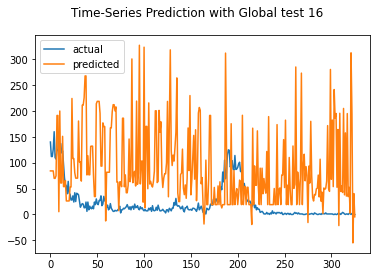

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 36.238
Test RMSE: 49.932
Test sMAPE: 129.845
Test R Squared: -1.295
{'mae': 36.23832548231435, 'rmse': 49.93197194936593, 'smape': 129.84462181221386, 'r2': -1.2947947727348508}


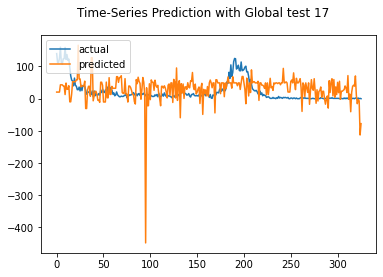

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 45.880
Test RMSE: 60.494
Test sMAPE: 152.155
Test R Squared: -2.368
{'mae': 45.87953727121002, 'rmse': 60.494243982742574, 'smape': 152.1551921046111, 'r2': -2.368329146890613}


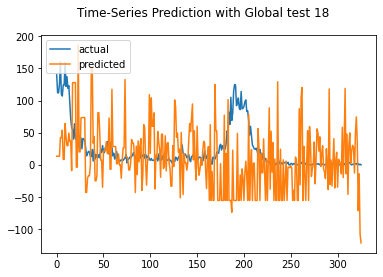

Test MAE: 116.453
Test RMSE: 137.851
Test sMAPE: 159.958
Test R Squared: -16.491
{'mae': 116.45310947097883, 'rmse': 137.85083423320503, 'smape': 159.95812893416522, 'r2': -16.49062036748279}


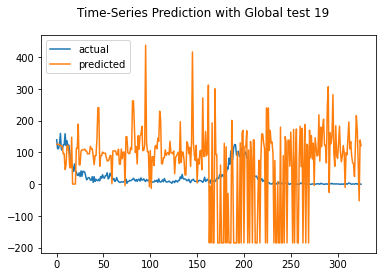

Test MAE: 50.052
Test RMSE: 63.983
Test sMAPE: 137.795
Test R Squared: -2.768
{'mae': 50.051985973777946, 'rmse': 63.98283800742026, 'smape': 137.79538745115514, 'r2': -2.7680218757966863}


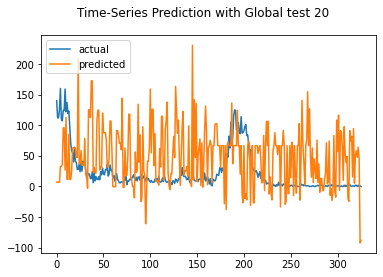

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 48.386
Test RMSE: 65.823
Test sMAPE: 144.065
Test R Squared: -2.988
{'mae': 48.38591720794607, 'rmse': 65.82314397633466, 'smape': 144.06543769551698, 'r2': -2.987894499046355}


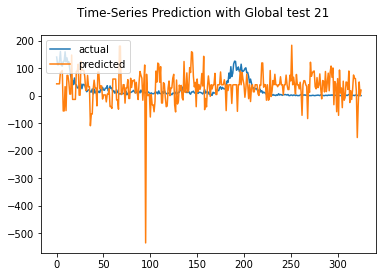

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 61.148
Test RMSE: 73.171
Test sMAPE: 148.452
Test R Squared: -3.928
{'mae': 61.147897566754395, 'rmse': 73.17098347745193, 'smape': 148.45244538510386, 'r2': -3.9279262639273194}


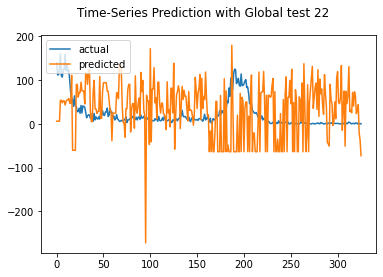

Test MAE: 104.236
Test RMSE: 138.550
Test sMAPE: 158.347
Test R Squared: -16.668
{'mae': 104.23638007026508, 'rmse': 138.54963882815866, 'smape': 158.34740098820038, 'r2': -16.668399568570365}


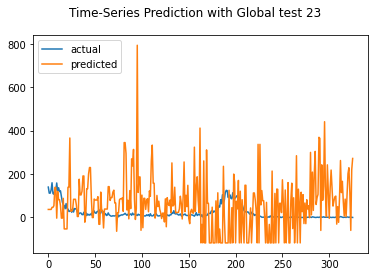

Test MAE: 51.413
Test RMSE: 69.167
Test sMAPE: 137.923
Test R Squared: -3.403
{'mae': 51.41347119120732, 'rmse': 69.16661667821823, 'smape': 137.92326062673263, 'r2': -3.4033122261582145}


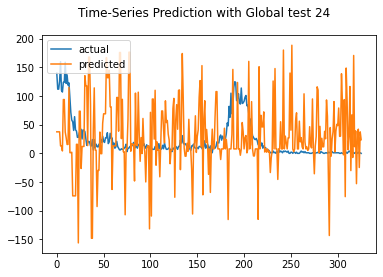

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 47.160
Test RMSE: 59.496
Test sMAPE: 143.251
Test R Squared: -2.258
{'mae': 47.160105294427986, 'rmse': 59.49580812025905, 'smape': 143.25136735013183, 'r2': -2.2580605546762076}


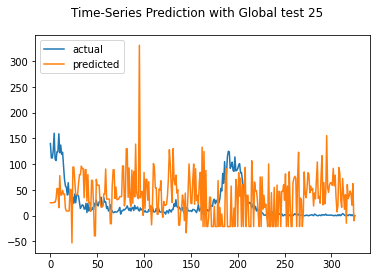

Test MAE: 71.216
Test RMSE: 91.865
Test sMAPE: 144.749
Test R Squared: -6.768
{'mae': 71.21608227308542, 'rmse': 91.86473398835336, 'smape': 144.74858627030227, 'r2': -6.767550040998333}


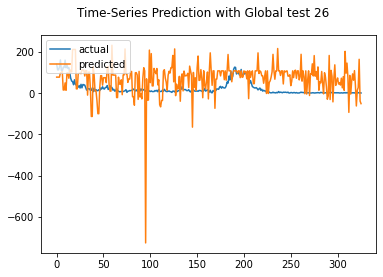

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 71.259
Test RMSE: 84.857
Test sMAPE: 157.005
Test R Squared: -5.628
{'mae': 71.25907125794815, 'rmse': 84.85692573659664, 'smape': 157.0052464466314, 'r2': -5.627671945778539}


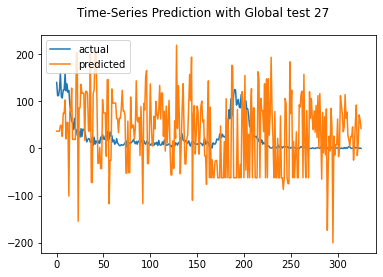

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 46.259
Test RMSE: 89.528
Test sMAPE: 144.814
Test R Squared: -6.377
{'mae': 46.25852615290258, 'rmse': 89.52796082265935, 'smape': 144.81384129758263, 'r2': -6.377407987242476}


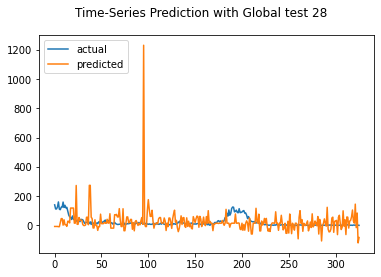

Test MAE: 49.263
Test RMSE: 60.165
Test sMAPE: 129.934
Test R Squared: -2.332
{'mae': 49.26298704469131, 'rmse': 60.16545618999899, 'smape': 129.9339313960236, 'r2': -2.3318147322692213}


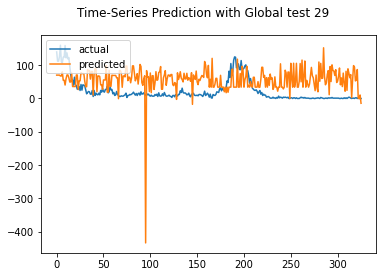

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 45.027
Test RMSE: 60.823
Test sMAPE: 130.886
Test R Squared: -2.405
{'mae': 45.02709906205443, 'rmse': 60.8232726137875, 'smape': 130.88624624230584, 'r2': -2.405069524735541}


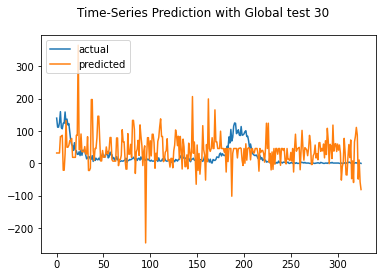

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 44.577
Test RMSE: 63.424
Test sMAPE: 134.871
Test R Squared: -2.702
{'mae': 44.576789113824354, 'rmse': 63.42369987052704, 'smape': 134.8707524477008, 'r2': -2.7024530742715185}


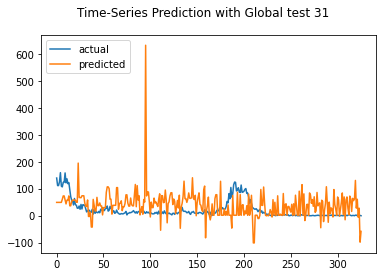

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 43.148
Test RMSE: 56.821
Test sMAPE: 124.421
Test R Squared: -1.972
{'mae': 43.147611769430476, 'rmse': 56.82142987648217, 'smape': 124.4214739471664, 'r2': -1.9717394717828771}


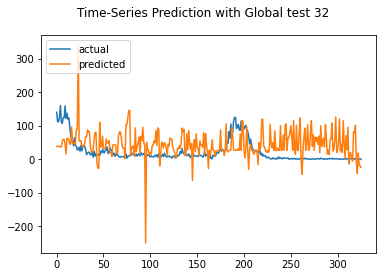

Test MAE: 89.367
Test RMSE: 127.055
Test sMAPE: 149.064
Test R Squared: -13.858
{'mae': 89.36722238041872, 'rmse': 127.05539921680726, 'smape': 149.06426773140032, 'r2': -13.858421236455527}


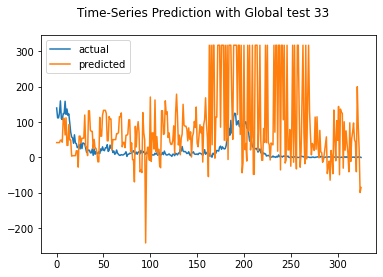

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 45.412
Test RMSE: 59.220
Test sMAPE: 143.343
Test R Squared: -2.228
{'mae': 45.411727813672435, 'rmse': 59.21968712153054, 'smape': 143.34317801965128, 'r2': -2.2278893076694555}


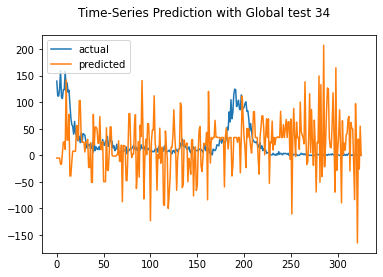

Test MAE: 94.083
Test RMSE: 150.297
Test sMAPE: 152.782
Test R Squared: -19.792
{'mae': 94.08259540467175, 'rmse': 150.29704607349052, 'smape': 152.78163626608332, 'r2': -19.79157103562622}


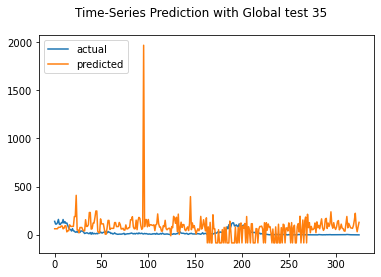

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 55.704
Test RMSE: 72.939
Test sMAPE: 155.700
Test R Squared: -3.897
{'mae': 55.70356880649467, 'rmse': 72.9393508525007, 'smape': 155.7002885611029, 'r2': -3.896775616345005}


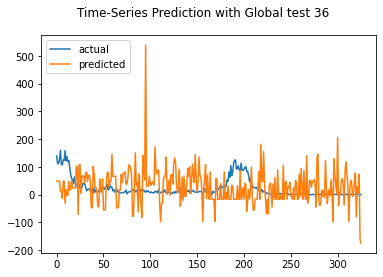

Test MAE: 83.581
Test RMSE: 100.716
Test sMAPE: 151.577
Test R Squared: -8.336
{'mae': 83.58099184153271, 'rmse': 100.71560897532635, 'smape': 151.57727887729516, 'r2': -8.336411444031475}


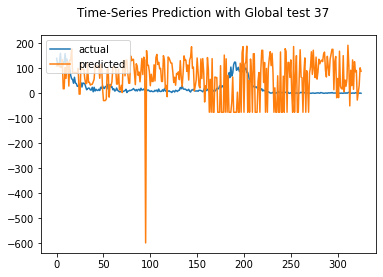

Test MAE: 83.989
Test RMSE: 125.528
Test sMAPE: 146.695
Test R Squared: -13.503
{'mae': 83.9892631385224, 'rmse': 125.52807306594518, 'smape': 146.69513716750618, 'r2': -13.503343752990828}


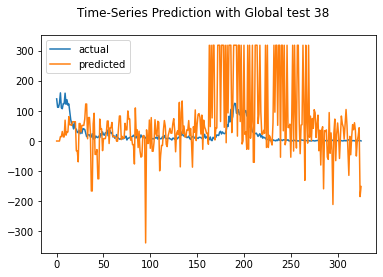

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 70.224
Test RMSE: 88.535
Test sMAPE: 154.160
Test R Squared: -6.215
{'mae': 70.22418784948945, 'rmse': 88.53532237544664, 'smape': 154.16049154577473, 'r2': -6.214721348828294}


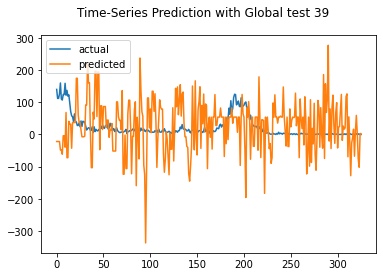

Test MAE: 53.063
Test RMSE: 73.140
Test sMAPE: 138.446
Test R Squared: -3.924
{'mae': 53.06258595903958, 'rmse': 73.1400445219034, 'smape': 138.44580208213816, 'r2': -3.9237597856064017}


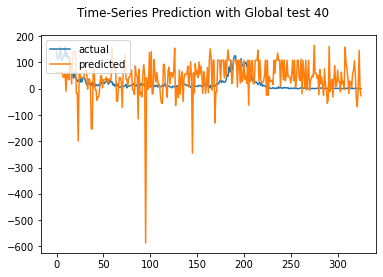

Test MAE: 55.836
Test RMSE: 65.769
Test sMAPE: 140.506
Test R Squared: -2.981
{'mae': 55.83597648290037, 'rmse': 65.768632643167, 'smape': 140.50634349816764, 'r2': -2.9812920969476138}


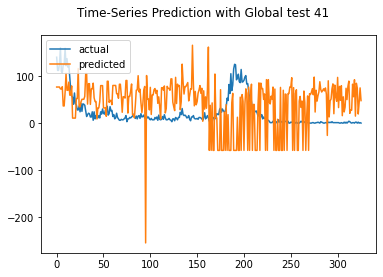

Test MAE: 94.654
Test RMSE: 121.649
Test sMAPE: 151.373
Test R Squared: -12.621
{'mae': 94.65386930601728, 'rmse': 121.64859323738268, 'smape': 151.37310736121538, 'r2': -12.62073671776919}


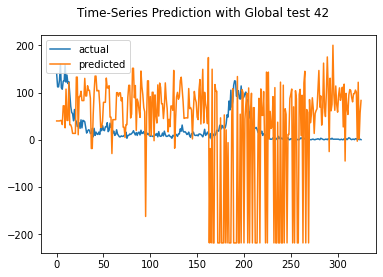

Test MAE: 47.480
Test RMSE: 63.625
Test sMAPE: 136.337
Test R Squared: -2.726
{'mae': 47.48041931178672, 'rmse': 63.62527989897717, 'smape': 136.3372125595732, 'r2': -2.72602554473836}


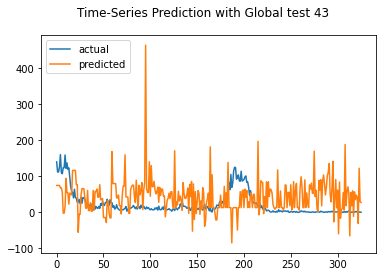

Test MAE: 120.988
Test RMSE: 146.063
Test sMAPE: 162.078
Test R Squared: -18.637
{'mae': 120.98776200121166, 'rmse': 146.0632448438789, 'smape': 162.0780698000946, 'r2': -18.636690947942395}


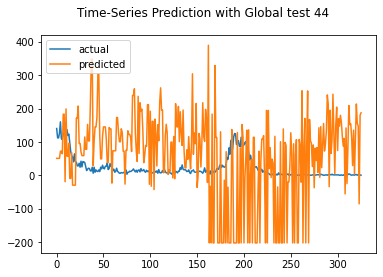

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 41.855
Test RMSE: 51.663
Test sMAPE: 130.497
Test R Squared: -1.457
{'mae': 41.854732225643346, 'rmse': 51.66343742502287, 'smape': 130.49707624748933, 'r2': -1.4567050204591654}


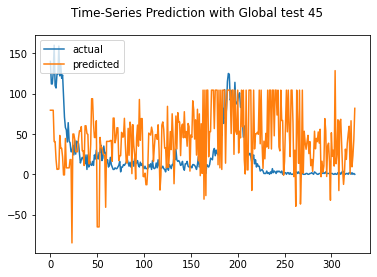

Test MAE: 53.645
Test RMSE: 60.528
Test sMAPE: 135.415
Test R Squared: -2.372
{'mae': 53.64463855737557, 'rmse': 60.52760180633094, 'smape': 135.41478319958225, 'r2': -2.3720449089520153}


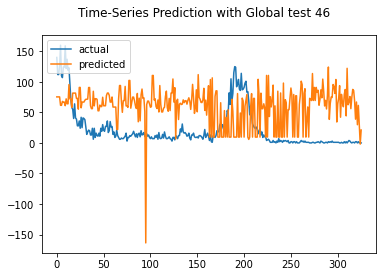

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 42.705
Test RMSE: 53.335
Test sMAPE: 127.342
Test R Squared: -1.618
{'mae': 42.7051063925942, 'rmse': 53.334980734327864, 'smape': 127.34156775463615, 'r2': -1.6182475228451234}


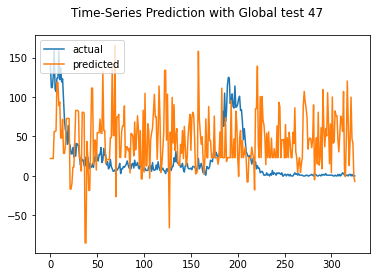

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 38.086
Test RMSE: 48.943
Test sMAPE: 127.814
Test R Squared: -1.205
{'mae': 38.08573570920646, 'rmse': 48.942558082214425, 'smape': 127.81365527567185, 'r2': -1.2047520038596855}


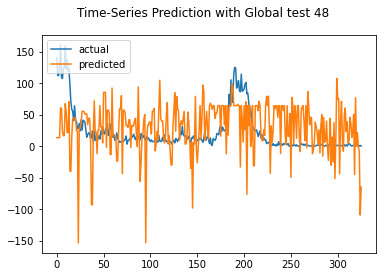

Test MAE: 59.762
Test RMSE: 67.704
Test sMAPE: 133.890
Test R Squared: -3.219
{'mae': 59.76228618676677, 'rmse': 67.70412739431445, 'smape': 133.88989470903502, 'r2': -3.2190697605093943}


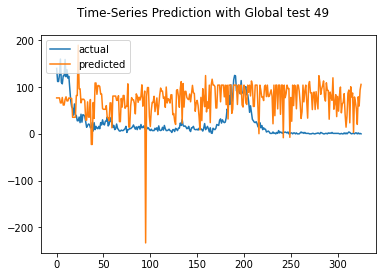

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 63.693
Test RMSE: 75.048
Test sMAPE: 143.251
Test R Squared: -4.184
{'mae': 63.69307321072356, 'rmse': 75.04773977904006, 'smape': 143.25076714054245, 'r2': -4.183960102239371}


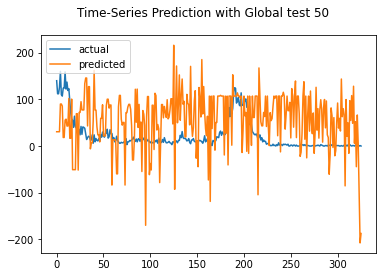

Test MAE: 87.947
Test RMSE: 122.389
Test sMAPE: 148.201
Test R Squared: -12.787
{'mae': 87.94730337101258, 'rmse': 122.38884233317751, 'smape': 148.20138844817097, 'r2': -12.787009343240097}


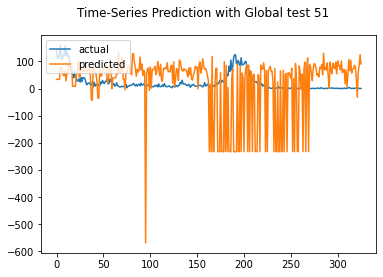

Test MAE: 70.286
Test RMSE: 100.289
Test sMAPE: 148.419
Test R Squared: -8.257
{'mae': 70.28631731127302, 'rmse': 100.28857932122158, 'smape': 148.41903480017277, 'r2': -8.257407357185793}


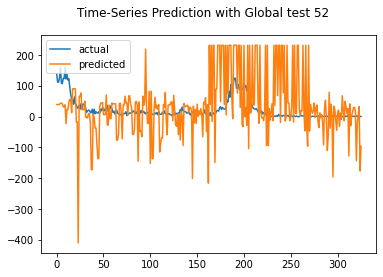

Test MAE: 124.343
Test RMSE: 188.877
Test sMAPE: 155.528
Test R Squared: -31.835
{'mae': 124.34282788076649, 'rmse': 188.87656418645028, 'smape': 155.52777837125015, 'r2': -31.835419125409437}


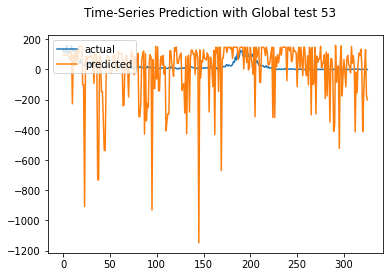

Test MAE: 53.103
Test RMSE: 83.151
Test sMAPE: 135.791
Test R Squared: -5.364
{'mae': 53.10303448853683, 'rmse': 83.1506067434582, 'smape': 135.7909458981602, 'r2': -5.363810830009015}


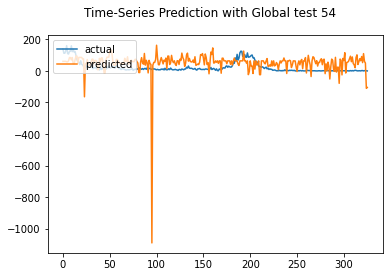

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 53.674
Test RMSE: 67.462
Test sMAPE: 140.106
Test R Squared: -3.189
{'mae': 53.67390132773142, 'rmse': 67.46198424706327, 'smape': 140.10605166796302, 'r2': -3.188944804626513}


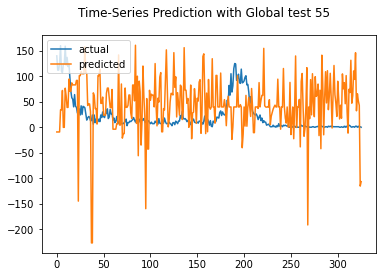

Test MAE: 166.829
Test RMSE: 214.125
Test sMAPE: 161.260
Test R Squared: -41.201
{'mae': 166.82928308826283, 'rmse': 214.12501569715224, 'smape': 161.25961389723406, 'r2': -41.20085323812207}


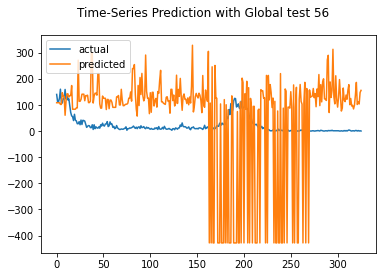

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 46.247
Test RMSE: 55.294
Test sMAPE: 128.946
Test R Squared: -1.814
{'mae': 46.24741248868726, 'rmse': 55.29360469539486, 'smape': 128.94581131347368, 'r2': -1.8140785958691596}


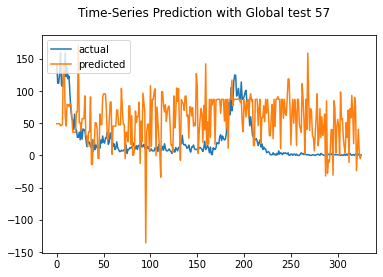

Test MAE: 70.905
Test RMSE: 85.846
Test sMAPE: 154.156
Test R Squared: -5.783
{'mae': 70.90501341351703, 'rmse': 85.84611693949606, 'smape': 154.15557249205588, 'r2': -5.783092310528816}


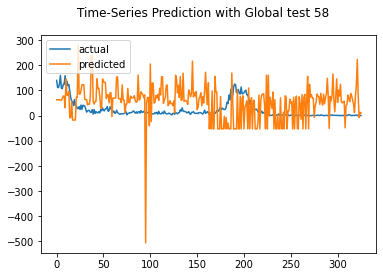

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 50.759
Test RMSE: 70.358
Test sMAPE: 131.843
Test R Squared: -3.556
{'mae': 50.75858237214981, 'rmse': 70.35793831246859, 'smape': 131.8430840435279, 'r2': -3.5563032992521633}


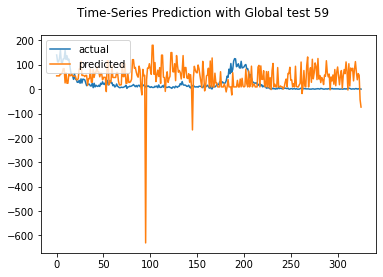

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 40.896
Test RMSE: 51.022
Test sMAPE: 129.930
Test R Squared: -1.396
{'mae': 40.89619528881611, 'rmse': 51.021857685822475, 'smape': 129.9304957346718, 'r2': -1.3960669584981966}


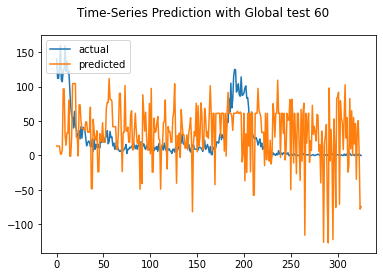

Test MAE: 115.497
Test RMSE: 124.801
Test sMAPE: 161.617
Test R Squared: -13.336
{'mae': 115.49725057449808, 'rmse': 124.80099335304183, 'smape': 161.6172891208943, 'r2': -13.335818715819016}


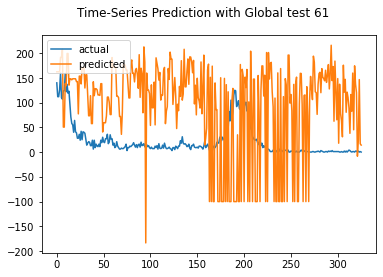

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 46.305
Test RMSE: 57.034
Test sMAPE: 148.078
Test R Squared: -1.994
{'mae': 46.30545612474892, 'rmse': 57.03434621648376, 'smape': 148.07805109981655, 'r2': -1.9940520870133}


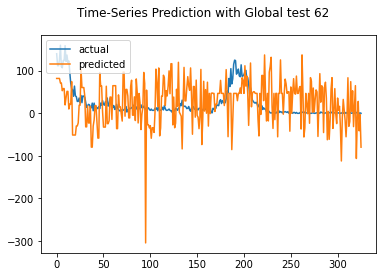

Test MAE: 85.834
Test RMSE: 99.127
Test sMAPE: 155.338
Test R Squared: -8.044
{'mae': 85.83365343757934, 'rmse': 99.12732216158832, 'smape': 155.3376857040975, 'r2': -8.044262623375383}


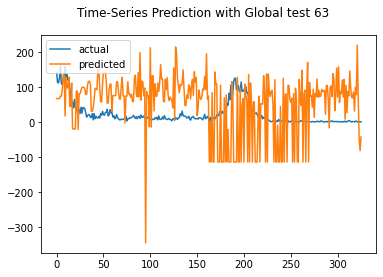

Test MAE: 88.678
Test RMSE: 102.735
Test sMAPE: 151.468
Test R Squared: -8.715
{'mae': 88.67757119485206, 'rmse': 102.73468959278225, 'smape': 151.4680459715968, 'r2': -8.714504244257412}


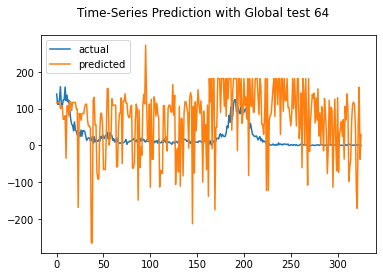

Test MAE: 113.486
Test RMSE: 150.842
Test sMAPE: 152.479
Test R Squared: -19.943
{'mae': 113.48601545329474, 'rmse': 150.84174281403563, 'smape': 152.47877676750915, 'r2': -19.94254702771726}


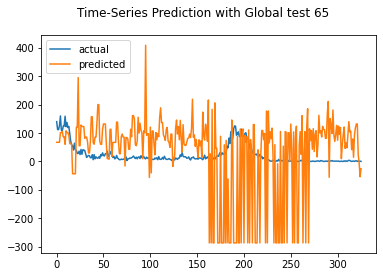

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 58.204
Test RMSE: 70.970
Test sMAPE: 140.558
Test R Squared: -3.636
{'mae': 58.2036689710032, 'rmse': 70.96975624421404, 'smape': 140.55838985442534, 'r2': -3.63588915533908}


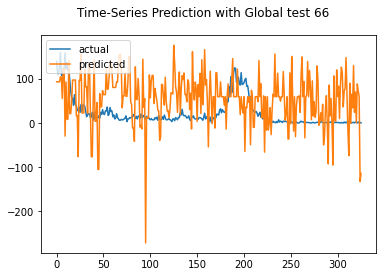

Test MAE: 62.249
Test RMSE: 74.600
Test sMAPE: 144.000
Test R Squared: -4.122
{'mae': 62.2486077344125, 'rmse': 74.60039824058929, 'smape': 143.99975566441339, 'r2': -4.122343611420122}


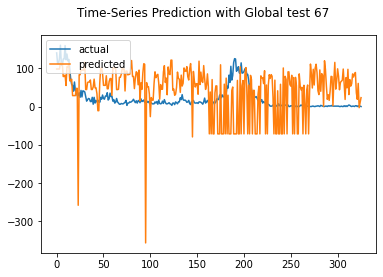

Test MAE: 77.285
Test RMSE: 117.847
Test sMAPE: 141.039
Test R Squared: -11.783
{'mae': 77.28474346168933, 'rmse': 117.8468025709941, 'smape': 141.0389938544141, 'r2': -11.782683138890533}


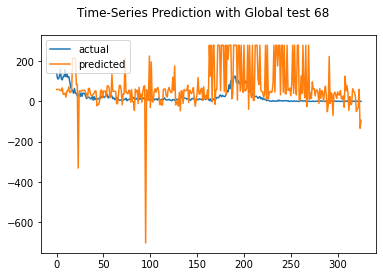

Test MAE: 93.661
Test RMSE: 119.608
Test sMAPE: 143.147
Test R Squared: -12.168
{'mae': 93.6611894508081, 'rmse': 119.60821998113785, 'smape': 143.1470472999905, 'r2': -12.167655952288877}


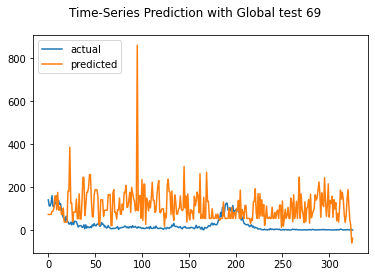

Test MAE: 56.067
Test RMSE: 78.557
Test sMAPE: 142.891
Test R Squared: -4.680
{'mae': 56.06721303909103, 'rmse': 78.55675005353535, 'smape': 142.8905152300755, 'r2': -4.680066658306247}


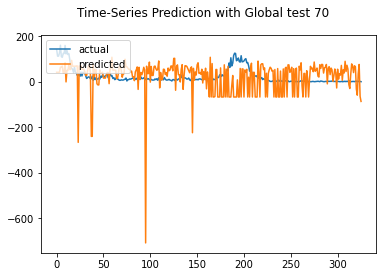

Test MAE: 139.641
Test RMSE: 204.723
Test sMAPE: 156.562
Test R Squared: -37.576
{'mae': 139.64059143435736, 'rmse': 204.72313472882115, 'smape': 156.56248872284488, 'r2': -37.57627259532685}


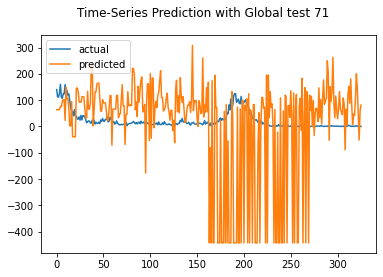

Test MAE: 79.369
Test RMSE: 93.721
Test sMAPE: 152.868
Test R Squared: -7.085
{'mae': 79.36946855000923, 'rmse': 93.72135299187981, 'smape': 152.8679335844612, 'r2': -7.084692670356242}


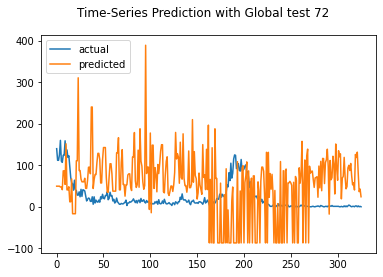

Test MAE: 48.250
Test RMSE: 58.629
Test sMAPE: 145.384
Test R Squared: -2.164
{'mae': 48.250209049853076, 'rmse': 58.62858705235347, 'smape': 145.3835041465812, 'r2': -2.1637726827305044}


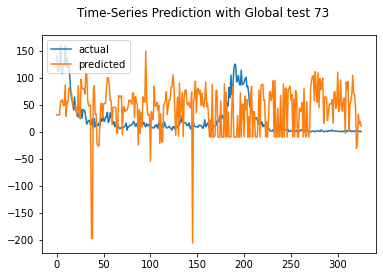

Test MAE: 69.976
Test RMSE: 93.816
Test sMAPE: 146.785
Test R Squared: -7.101
{'mae': 69.97579851033497, 'rmse': 93.81595134416199, 'smape': 146.7853415538489, 'r2': -7.101021597724607}


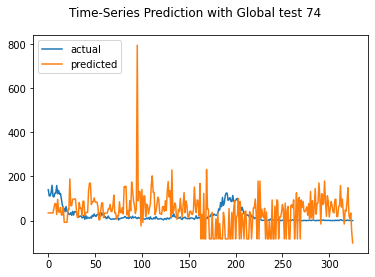

Test MAE: 103.049
Test RMSE: 171.008
Test sMAPE: 150.961
Test R Squared: -25.917
{'mae': 103.04864662647978, 'rmse': 171.00820640694886, 'smape': 150.96124625864334, 'r2': -25.91660740916769}


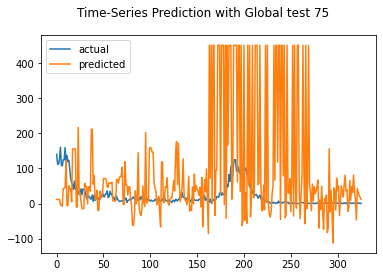

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 55.020
Test RMSE: 71.194
Test sMAPE: 149.624
Test R Squared: -3.665
{'mae': 55.02038555606011, 'rmse': 71.19446629375936, 'smape': 149.6238703415891, 'r2': -3.6652926686752405}


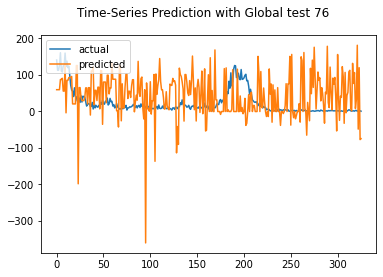

Test MAE: 75.952
Test RMSE: 97.963
Test sMAPE: 162.046
Test R Squared: -7.833
{'mae': 75.95150899594547, 'rmse': 97.96283082570844, 'smape': 162.04638124592387, 'r2': -7.833017056170755}


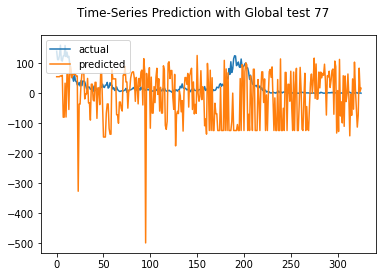

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 62.970
Test RMSE: 80.149
Test sMAPE: 142.777
Test R Squared: -4.913
{'mae': 62.970096690523114, 'rmse': 80.14888326389644, 'smape': 142.7771999466456, 'r2': -4.912639050571535}


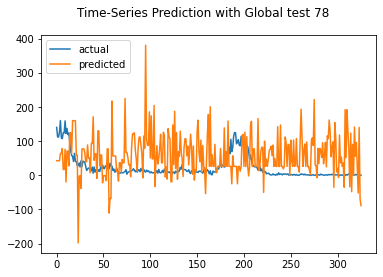

Test MAE: 44.742
Test RMSE: 56.301
Test sMAPE: 138.734
Test R Squared: -1.918
{'mae': 44.742179283700835, 'rmse': 56.30062566466151, 'smape': 138.73445401966714, 'r2': -1.917513394076166}


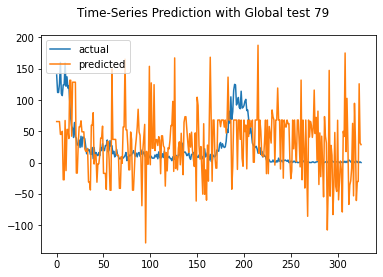

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 50.459
Test RMSE: 62.573
Test sMAPE: 134.701
Test R Squared: -2.604
{'mae': 50.45921589361012, 'rmse': 62.57255942182944, 'smape': 134.7013076553064, 'r2': -2.6037466776810536}


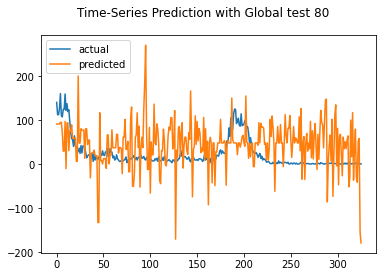

Test MAE: 67.686
Test RMSE: 92.273
Test sMAPE: 134.578
Test R Squared: -6.837
{'mae': 67.68567390959322, 'rmse': 92.27253094228908, 'smape': 134.57758464079413, 'r2': -6.836665004303756}


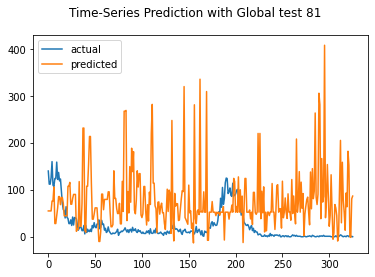

Test MAE: 109.029
Test RMSE: 132.483
Test sMAPE: 156.759
Test R Squared: -15.155
{'mae': 109.02884883529569, 'rmse': 132.48253029640318, 'smape': 156.7587311010781, 'r2': -15.154876582683606}


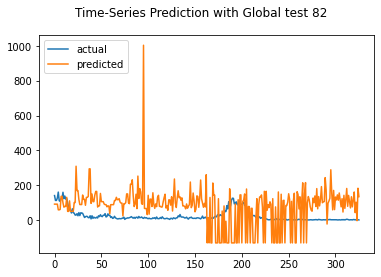

Test MAE: 70.735
Test RMSE: 81.103
Test sMAPE: 148.476
Test R Squared: -5.054
{'mae': 70.73463285773809, 'rmse': 81.10255829936582, 'smape': 148.4759147119627, 'r2': -5.054182715443457}


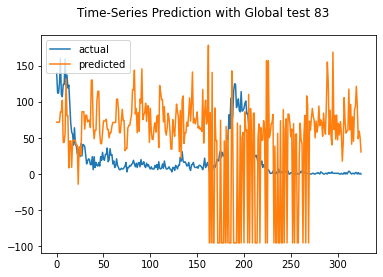

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 55.702
Test RMSE: 72.356
Test sMAPE: 150.736
Test R Squared: -3.819
{'mae': 55.70231445691337, 'rmse': 72.35610372218537, 'smape': 150.73618219658104, 'r2': -3.818776253529683}


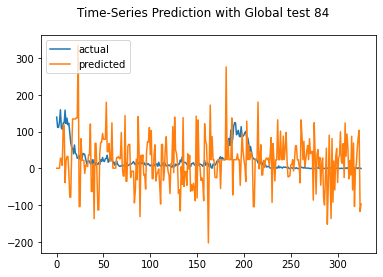

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 44.094
Test RMSE: 70.504
Test sMAPE: 137.010
Test R Squared: -3.575
{'mae': 44.09390050355642, 'rmse': 70.50438767891809, 'smape': 137.01026927223498, 'r2': -3.5752908421849208}


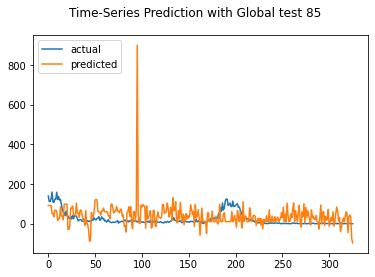

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 81.813
Test RMSE: 104.768
Test sMAPE: 148.343
Test R Squared: -9.103
{'mae': 81.81285010543337, 'rmse': 104.76848225670828, 'smape': 148.3431712856855, 'r2': -9.102938776601908}


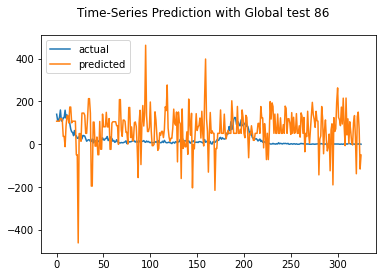

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 53.689
Test RMSE: 81.437
Test sMAPE: 144.636
Test R Squared: -5.104
{'mae': 53.68862821536561, 'rmse': 81.43700805021606, 'smape': 144.63626230158187, 'r2': -5.104218001808262}


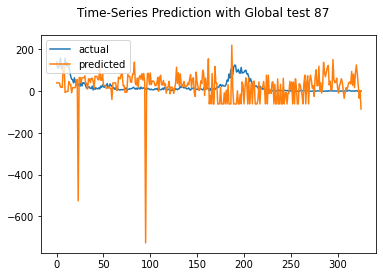

Test MAE: 93.125
Test RMSE: 109.688
Test sMAPE: 148.118
Test R Squared: -10.074
{'mae': 93.12456290085623, 'rmse': 109.68762804475118, 'smape': 148.11790230686353, 'r2': -10.073928279277169}


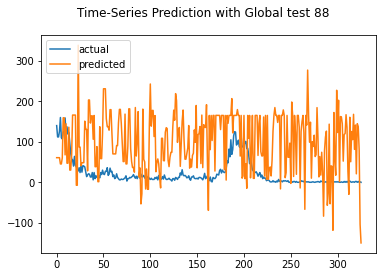

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 48.234
Test RMSE: 58.965
Test sMAPE: 132.604
Test R Squared: -2.200
{'mae': 48.23365807167591, 'rmse': 58.964663624719336, 'smape': 132.60424564683416, 'r2': -2.200148021889479}


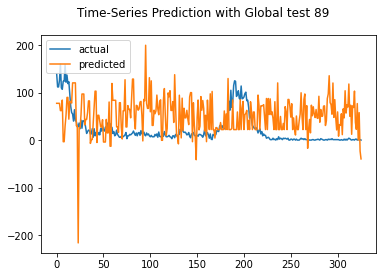

Test MAE: 134.852
Test RMSE: 204.483
Test sMAPE: 161.819
Test R Squared: -37.486
{'mae': 134.8517044387712, 'rmse': 204.48259743655893, 'smape': 161.8192989041055, 'r2': -37.48567627833168}


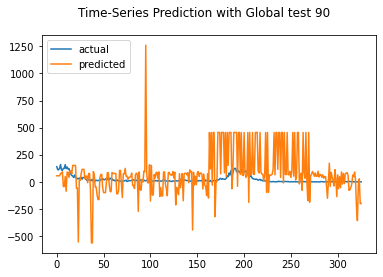

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 71.485
Test RMSE: 88.648
Test sMAPE: 148.403
Test R Squared: -6.233
{'mae': 71.48531973471671, 'rmse': 88.6476053852826, 'smape': 148.40344469895766, 'r2': -6.233032781969194}


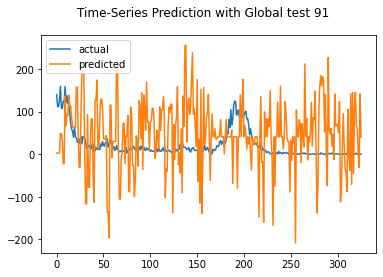

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 49.070
Test RMSE: 61.561
Test sMAPE: 143.463
Test R Squared: -2.488
{'mae': 49.06960831043179, 'rmse': 61.561464755767155, 'smape': 143.46348766092555, 'r2': -2.488223514993252}


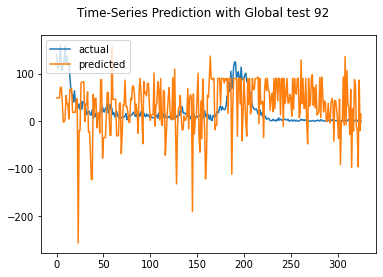

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 47.902
Test RMSE: 67.453
Test sMAPE: 136.403
Test R Squared: -3.188
{'mae': 47.90210949515272, 'rmse': 67.45345019476952, 'smape': 136.40330844662793, 'r2': -3.1878850548049167}


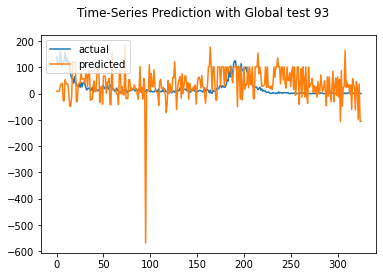

Test MAE: 56.336
Test RMSE: 72.842
Test sMAPE: 132.887
Test R Squared: -3.884
{'mae': 56.3360183917306, 'rmse': 72.842348247759, 'smape': 132.887293975345, 'r2': -3.8837597577995195}


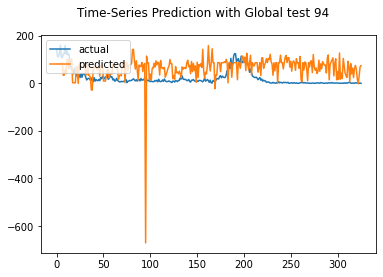

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 68.816
Test RMSE: 90.494
Test sMAPE: 155.344
Test R Squared: -6.538
{'mae': 68.81625937464779, 'rmse': 90.49419491599969, 'smape': 155.34403818461954, 'r2': -6.53750924052622}


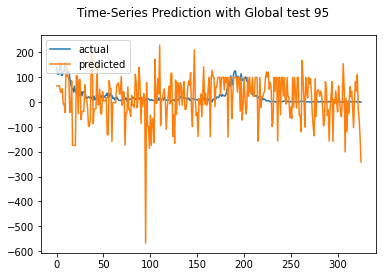

Test MAE: 89.048
Test RMSE: 139.091
Test sMAPE: 139.879
Test R Squared: -16.807
{'mae': 89.04779342072872, 'rmse': 139.091280909498, 'smape': 139.87915446269474, 'r2': -16.80681429187423}


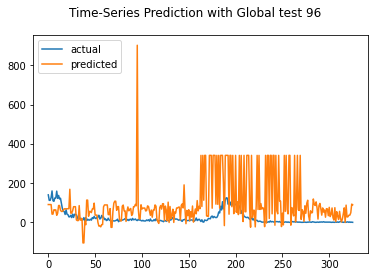

Test MAE: 93.018
Test RMSE: 127.282
Test sMAPE: 152.122
Test R Squared: -13.912
{'mae': 93.01756128531657, 'rmse': 127.28216447379542, 'smape': 152.12197018937212, 'r2': -13.911506434208958}


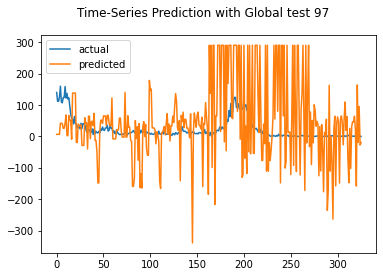

Test MAE: 52.660
Test RMSE: 61.155
Test sMAPE: 145.940
Test R Squared: -2.442
{'mae': 52.65972055302807, 'rmse': 61.15473632495095, 'smape': 145.93979020236753, 'r2': -2.4422833183551416}


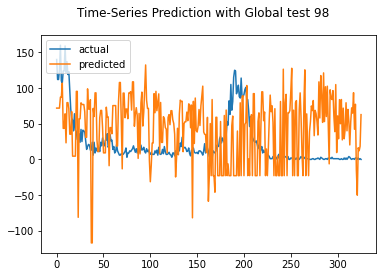

Test MAE: 80.976
Test RMSE: 92.487
Test sMAPE: 143.869
Test R Squared: -6.873
{'mae': 80.97555628876013, 'rmse': 92.48709614260841, 'smape': 143.86878020705132, 'r2': -6.873153232865061}


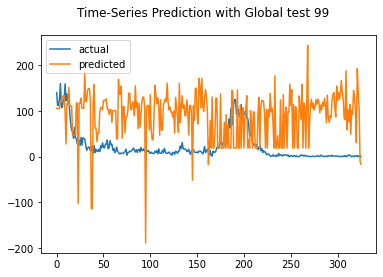

rmse : average=91.306, std=35.451
mae : average=69.198, std=24.982
smape : average=144.187, std=9.682
r2 : average=-7.830, std=7.786


([91.3063883755168, 35.45134359146442],
 [69.19792680000415, 24.98200187393725],
 [144.18679465163373, 9.68150240872213],
 [-7.830198817231178, 7.785737679323277])

In [13]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=False, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')
